In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt 

Вводные

Водитель может находиться в 4 возможных статусах:
    * free -- доступен для нового заказа
    * enroute -- едет на заказ
    * ontrip -- выполняет заказ
    * busy -- недоступен для нового заказа

Возможные переходы из одного состояние в другое определены как:
    * free -> [free, enroute, busy]
    * enroute -> [free, ontrip]
    * ontrip -> [free]
    * busy -> [free]

Почему переходы определяются таким образом:
1. Из состояния free можно перейти в
    * free -- если водитель ушел в офлайн и заново вышел на линию, тогда подряд будет две записи со статусом free
    * enroute -- если водитель принял заказ, то переходит в статус enroute и едет к клиенту
    * busy -- если водитель нажал кнопку "Занят" в таксометре (пошел на обед и т.д.)
2. Из состояния enroute можно перейти в 
    * free -- если клиент или водитель отменил заказ
    * ontrip -- если водитель приехал к клиенту и начал выполнять заказ
3. Из состояния ontrip можно перейти только в free (после выполнения заказа)
4. Из состояния busy можно перейти только в free

Эффективность на поездке -- это время с клиентом в машине (ontrip), деленное на сумму длительностей всех статусов, связанных с поездкой (sum(free) + enroute + ontrip), где sum(free) -- время простоя.

Время простоя -- это сумма всех статусов free, предшествующих поездке. Суммируются все статусы free, идущие подряд, а также те, которые были прерваны короткими статусами busy или enroute (короткий статус == меньше какого-то TIMEOUT'а).

Имеется набор данных со статусами водителей, по которому необходимо построить зависимость длительности поездки от эффективности.
    * driver_id -- id водителя
    * status -- один из статусов
    * dttm -- время начала статуса

Примечания:
    * Поездка считается только при наличии статуса ontrip
    * Тесты написаны для python 2

    1. Написать функцию-генератор, которая будет отдавать соседние элементы в цикле. Функция понадобится для итерирования по записям водителя и проверки соседних статусов по условиям. Не забудьте проверить, что тесты проходят без ошибок (см. test_neighbors).

In [2]:
def neighbors(iterable):
    # Write generator function which yields 
    # previous, current and next values in iterable list.
    # ... type your code here ...
    for i,val in enumerate(iterable):
        if (len(iterable)>1):
            if (i == 0):
                yield (None,val,iterable[i+1])
            elif i == len(iterable)-1:
                yield (iterable[i-1],val,None)
            else:
                yield (iterable[i-1],val,iterable[i+1])
        else:
            yield (None,val,None)
        
            

In [3]:
# Check if test passes
def test_neighbors():
    test_neighbors = neighbors( range(2) )
    assert next(test_neighbors) == (None, 0, 1)


test_neighbors()

    2. Сгруппировать данные на уровне водителя таким образом, чтобы в одной строке находились все его записи со статусами и началом статуса списком:

Формат исходной таблицы:
<table>
<tr><td>driver_id</td><td>status</td><td>dttm</td></tr>
<tr><td>9f8f9bf3ee8f4874873288c246bd2d05</td><td>free</td><td>2018-02-04 00:19</td></tr>
<tr><td>9f8f9bf3ee8f4874873288c246bd2d05</td><td>busy</td><td>2018-02-04 01:03</td></tr>
<tr><td>8f174ffd446c456eaf3cca0915d0368d</td><td>free</td><td>2018-02-03 15:43</td></tr>
<tr><td>8f174ffd446c456eaf3cca0915d0368d</td><td>enroute</td><td>2018-02-03 17:02</td></tr>
<tr><td>...</td><td>...</td><td>...</td></tr>
</table>

Формат сгруппированной таблицы:
<table>
<tr><td>driver_id</td><td>driver_info</td></tr>
<tr><td>9f8f9bf3ee8f4874873288c246bd2d05</td><td>[("free", 2018-02-04 00:19), ("busy", 2018-02-04 01:03)]</td></tr>
<tr><td>8f174ffd446c456eaf3cca0915d0368d</td><td>[("free", 2018-02-03 15:43), ("enroute", 2018-02-03 17:02) ...]</td></tr>
</table>

In [4]:
def combine_status_time(x):
    sorted_x = x.sort_values('dttm')
    return list(zip(x['status'],x['dttm']))

In [5]:
df = pd.read_csv("dataset.csv", parse_dates=["dttm"])
# ... type your code here ...
df = df.groupby('driver_id').apply(lambda x: combine_status_time(x)).reset_index()

In [6]:
df.columns = ['driver_id','driver_info']

In [7]:
df[:5]

,driver_id,driver_info
0,029e9b80b45c483fbb00c4695c2d9c09,"[(free, 2018-02-18 20:01:18.620339), (enroute,..."
1,041ddc65a16649129eb6dbee9b54d6e8,"[(free, 2018-02-18 19:56:21.620339), (busy, 20..."
2,048459e02e63450d9429ceb34601929d,"[(free, 2018-02-18 19:49:55.620339), (enroute,..."
3,0f8eccff510f4bdabbff9f40b2262517,"[(free, 2018-02-18 21:02:40.620339), (busy, 20..."
4,14637bc848b24ac49fbadc43d207e375,"[(free, 2018-02-18 20:36:13.620339), (enroute,..."


    3. Используя функцию neighbors, написать функцию, которая для каждой записи в списке driver_info посчитает ее длительность.

In [8]:
def calc_status_duration(driver_info):
    driver_info_updated = []
    for i, j, k in neighbors(driver_info):
        try:
            driver_info_updated.append((j[0],j[1],(k[1]-j[1]).seconds))
        except TypeError:
            driver_info_updated.append((j[0],j[1],None))
       # ... type your code here ...
    return driver_info_updated

In [9]:
# Check if test passes
def test_calc_status_duration():
    sample_driver_info = [("free", datetime(2018, 4, 2, 0, 19)), 
                          ("busy", datetime(2018, 4, 2, 1, 3)),]
    sample_driver_info_updated = [('free', datetime(2018, 4, 2, 0, 19), 2640.0),
                                  ('busy', datetime(2018, 4, 2, 1, 3), None),]
    assert calc_status_duration(sample_driver_info) == sample_driver_info_updated

test_calc_status_duration()

In [10]:
df["driver_info"] = df.driver_info.apply(calc_status_duration)

In [11]:
df[:5]

,driver_id,driver_info
0,029e9b80b45c483fbb00c4695c2d9c09,"[(free, 2018-02-18 20:01:18.620339, 2499), (en..."
1,041ddc65a16649129eb6dbee9b54d6e8,"[(free, 2018-02-18 19:56:21.620339, 2862), (bu..."
2,048459e02e63450d9429ceb34601929d,"[(free, 2018-02-18 19:49:55.620339, 1233), (en..."
3,0f8eccff510f4bdabbff9f40b2262517,"[(free, 2018-02-18 21:02:40.620339, 1574), (bu..."
4,14637bc848b24ac49fbadc43d207e375,"[(free, 2018-02-18 20:36:13.620339, 1271), (en..."


    4. Используя функцию neighbors, написать функцию, которая сформирует из списка driver_info список поездок с информацией о длительности поездки и эффективности (duration_ontrip, efficiency).

In [12]:
TIMEOUT = 1600

def collapse_statuses(driver_info):
    # Here define conditions under which the "free" state 
    # should be attributed to the trip.
    # ... type your code here ...
    trips = []
    trips_len = 0
    for i, j, k in neighbors(driver_info):
        if None not in [i,k]:
        
            if (i[0],j[0],k[0]) in [('free','free','free'),('free','enroute','ontrip'),('enroute','free','enroute'),('ontrip','free','enroute'),('busy','free','enroute'),
                                   ('enroute','free','busy'),('ontrip','free','busy'),('busy','free','busy')]:
                trips_len += j[2]
                
            elif (i[0],j[0],k[0]) == ('enroute','ontrip','free'):
                trips_len += j[2]
                trips.append((j[2],j[2]/trips_len))
                trips_len = 0
            elif (i[0],j[0],k[0]) in [('free','busy','free'),('free','enroute','free')]:
                if j[2] >= TIMEOUT:
                    trips_len = 0
                else:
                    trips_len += j[2]
                
        elif (i,j[0]) == (None,'free'):
            trips_len += j[2]
       
   
    return trips

In [13]:
# Check if test passes
def test_collapse_statuses():
    sample_driver_info = [("free", datetime(2018, 4, 2, 0, 19), 2640.0), 
                          ("busy", datetime(2018, 4, 2, 1, 3), 1660.0),
                          ("free", datetime(2018, 4, 2, 1, 30, 40), 2050.0),
                          ("enroute", datetime(2018, 4, 2, 2, 4, 50), 70.0),
                          ("free", datetime(2018, 4, 2, 2, 6), 500.0),
                          ("enroute", datetime(2018, 4, 2, 2, 14, 20), 520.0),
                          ("ontrip", datetime(2018, 4, 2, 2, 23), 3060.0),
                          ("free", datetime(2018, 4, 2, 3, 14), None)
                         ]
    sample_driver_info_updated = [(3060.0, 3060.0 / (3060.0 + 520.0 + 500.0 + 2050.0+70.0))]#+70?
    assert collapse_statuses(sample_driver_info) == sample_driver_info_updated

test_collapse_statuses()

In [14]:
df["driver_info"] = df.driver_info.apply(collapse_statuses)

    5. Нарисовать и проинтерпретировать зависимость между длительностью поездки и эффективностью.
    Подсказка: требуется сделать обратное преобразование из таблицы со строками на уровне водителя в таблицу со строками на уровне поездки.

In [15]:
df[:5]

,driver_id,driver_info
0,029e9b80b45c483fbb00c4695c2d9c09,"[(4561, 0.4108268780399928), (3622, 0.36314417..."
1,041ddc65a16649129eb6dbee9b54d6e8,"[(2985, 0.41724909141738886), (5845, 0.5580485..."
2,048459e02e63450d9429ceb34601929d,"[(1116, 0.2014076881429345), (5261, 0.27961732..."
3,0f8eccff510f4bdabbff9f40b2262517,"[(2780, 0.2212847249860702), (3580, 0.29616148..."
4,14637bc848b24ac49fbadc43d207e375,"[(4526, 0.4395028160807924), (149, 0.010557641..."


In [31]:
data = pd.DataFrame(df['driver_info'].apply(pd.Series).stack().values)

In [32]:
data['trips_len'] = data[0].apply(lambda x: x[0])
data['eff'] = data[0].apply(lambda x: x[1])

In [33]:
data[:4]

,0,trips_len,eff
0,"(4561, 0.4108268780399928)",4561,0.410827
1,"(3622, 0.363144174854622)",3622,0.363144
2,"(2985, 0.41724909141738886)",2985,0.417249
3,"(5845, 0.5580485010502196)",5845,0.558049


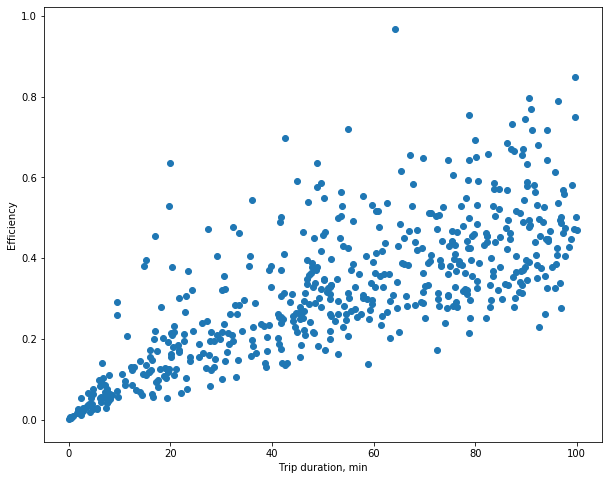

In [40]:
plt.figure(figsize=(10,8))
plt.xlabel('Trip duration, min')
plt.ylabel('Efficiency')
plt.scatter(data['trips_len']/60,data['eff']);

Средняя эффективность поездки растет с увеличением ее длительности. Это означает, что время в пути растет быстрее, чем время ожидания.